# New section

--- Electric Motor Temperature Prediction Project ---
Target: Permanent Magnet (PM) Temperature Prediction

Dataset loaded successfully.


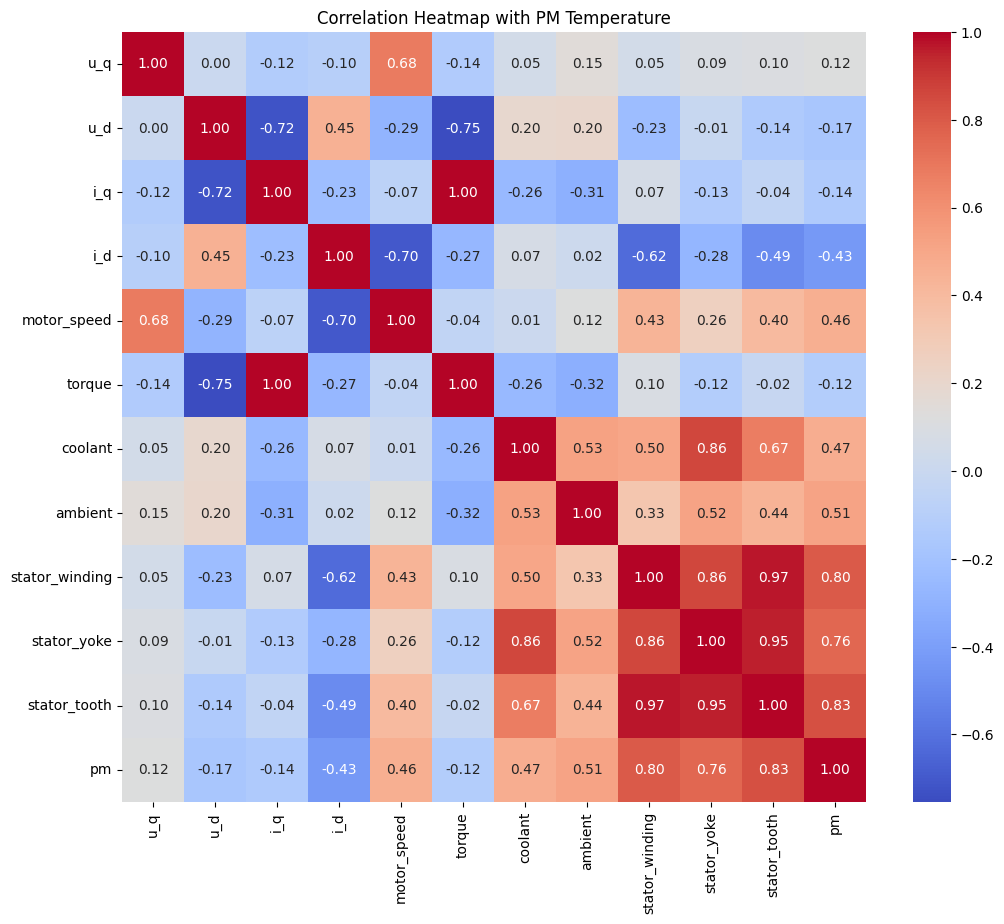

Original dataset shape: (1330816, 13)
Training set shape: (1039968, 11), (1039968,)
Testing set shape: (290848, 11), (290848,)

Features scaled using MinMaxScaler.

Training Random Forest Regressor...
Random Forest Regressor training complete.

Evaluating Model Performance...
Mean Squared Error (MSE): 102.2856
Root Mean Squared Error (RMSE): 10.1136
Mean Absolute Error (MAE): 6.8701
R-squared (R2 Score): 0.7273



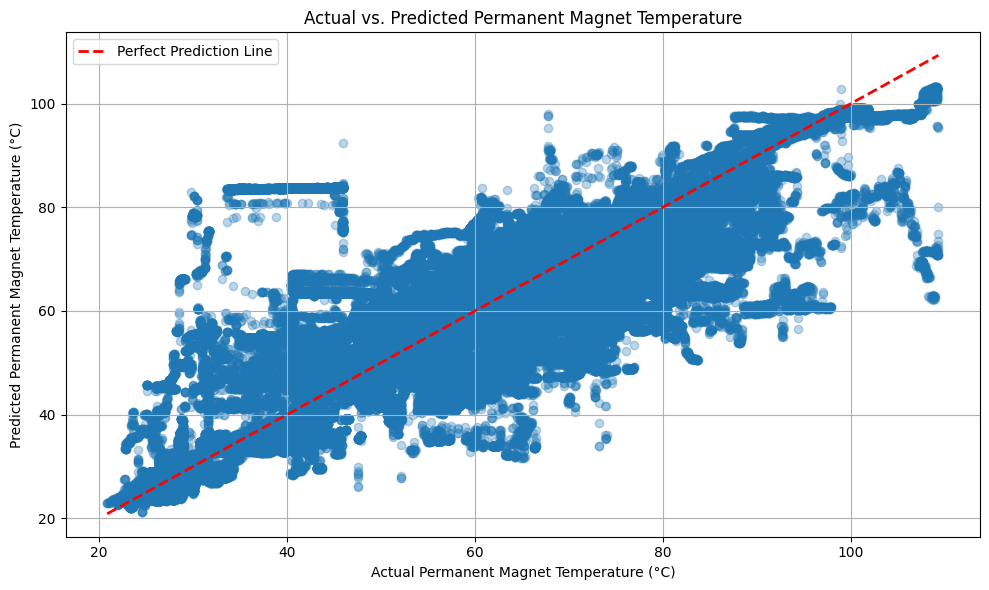

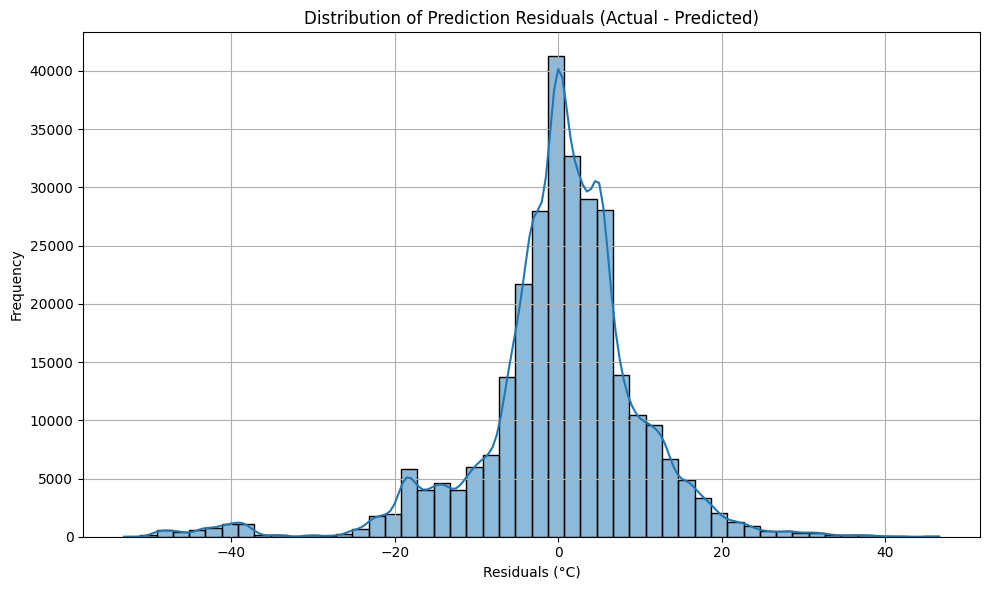

Feature Importances:
stator_tooth      0.650430
stator_yoke       0.080507
ambient           0.068597
coolant           0.050643
motor_speed       0.040387
torque            0.038594
u_q               0.019886
i_q               0.018671
u_d               0.016029
i_d               0.008724
stator_winding    0.007532
dtype: float64


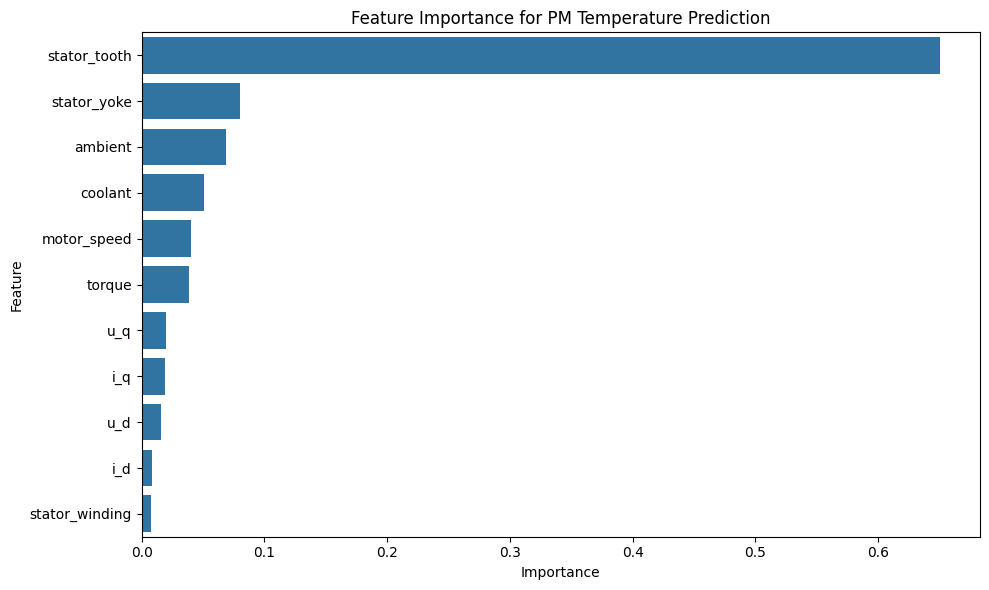


Model and Scaler saved successfully as 'pm_temp_random_forest_model.pkl' and 'pm_temp_scaler.pkl'.

--- Example: Loading Model and Making a New Prediction ---

New Data Point Features: {'u_q': 0.5, 'u_d': 0.1, 'i_q': 5.0, 'i_d': -2.0, 'motor_speed': 1800.0, 'torque': 10.0, 'coolant': 45.0, 'ambient': 30.0, 'stator_winding': 60.0, 'stator_yoke': 55.0, 'stator_tooth': 50.0}
Predicted Permanent Magnet Temperature: 55.48 °C

Project complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

print("--- Electric Motor Temperature Prediction Project ---")
print("Target: Permanent Magnet (PM) Temperature Prediction\n")

# --- 1. Load Data ---
try:
    df = pd.read_csv('measures_v2.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'measures_v2.csv' not found.")
    print("Please download it from Kaggle and place it in the same directory.")
    exit()

# --- 2. Data Preprocessing ---
features = ['u_q', 'u_d', 'i_q', 'i_d', 'motor_speed', 'torque',
            'coolant', 'ambient', 'stator_winding', 'stator_yoke', 'stator_tooth']
target = 'pm'

df = df.dropna(subset=features + [target])

plt.figure(figsize=(12, 10))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with PM Temperature")
plt.show()

unique_profile_ids = df['profile_id'].unique()
train_ids, test_ids = train_test_split(unique_profile_ids, test_size=0.2, random_state=42)

train_df = df[df['profile_id'].isin(train_ids)]
test_df = df[df['profile_id'].isin(test_ids)]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Original dataset shape: {df.shape}")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}\n")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using MinMaxScaler.\n")

# --- 3. Model Training ---
print("Training Random Forest Regressor...")
model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print("Random Forest Regressor training complete.\n")

# --- 4. Model Evaluation ---
print("Evaluating Model Performance...")
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}\n")

# --- 5. Visualization ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Permanent Magnet Temperature (°C)")
plt.ylabel("Predicted Permanent Magnet Temperature (°C)")
plt.title("Actual vs. Predicted Permanent Magnet Temperature")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title("Distribution of Prediction Residuals (Actual - Predicted)")
plt.xlabel("Residuals (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6. Feature Importance ---
print("Feature Importances:")
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance for PM Temperature Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- 7. Save Model and Scaler ---
joblib.dump(model, 'pm_temp_random_forest_model.pkl')
joblib.dump(scaler, 'pm_temp_scaler.pkl')
print("\nModel and Scaler saved successfully as 'pm_temp_random_forest_model.pkl' and 'pm_temp_scaler.pkl'.")

# --- 8. Load & Predict New Data ---
print("\n--- Example: Loading Model and Making a New Prediction ---")
try:
    loaded_model = joblib.load('pm_temp_random_forest_model.pkl', mmap_mode='r')
    loaded_scaler = joblib.load('pm_temp_scaler.pkl', mmap_mode='r')
except MemoryError as e:
    print(f"MemoryError: {e}. File size: {os.path.getsize('pm_temp_random_forest_model.pkl')} bytes")
    print("Try further reducing model complexity or increasing system memory.")
    exit()

new_data_point = np.array([[0.5, 0.1, 5.0, -2.0, 1800.0, 10.0, 45.0, 30.0, 60.0, 55.0, 50.0]])
new_data_df = pd.DataFrame(new_data_point, columns=features)
scaled_new_data = loaded_scaler.transform(new_data_df)
predicted_pm_temp = loaded_model.predict(scaled_new_data)[0]

print(f"\nNew Data Point Features: {new_data_df.iloc[0].to_dict()}")
print(f"Predicted Permanent Magnet Temperature: {predicted_pm_temp:.2f} °C")
print("\nProject complete.")